In [23]:
import itertools
from typing import Iterable
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, mannwhitneyu
from pathlib import Path

In [24]:
from typing import NamedTuple


class OurDataFrame(NamedTuple):
    with_outliers: pd.DataFrame

In [25]:
# https://saturncloud.io/blog/how-to-detect-and-exclude-outliers-in-a-pandas-dataframe/

def find_outliers(
    data: pd.DataFrame,
    column: str,
    threshold: float = 1.5,
    quantile_1: float = 0.25,
    quantile_2: float = 0.75,
) -> pd.DataFrame:
    q1 = data[column].quantile(quantile_1)
    q2 = data[column].quantile(quantile_2)
    iqr = q2 - q1

    return data[
        (data[column] < q1 - threshold * iqr)
        |
        (data[column] > q2 + threshold * iqr)
        ]


def drop_outliers(data: pd.DataFrame, columns: Iterable[str]) -> pd.DataFrame:
    # Identify outliers in source data
    column_outliers = [
        find_outliers(data, column)
        for column in columns
    ]

    # Drop outliers from source data
    datacopy = data.copy()
    total_outliers = sum(len(outliers) for outliers in column_outliers)

    print(
        f"Dropping {100 * total_outliers / len(datacopy):.2f}% outliers ({total_outliers} out of {len(datacopy)}) for columns {columns}")

    for outliers in column_outliers:
        # We ignore errors, because one row can be an outlier in multiple columns
        datacopy = datacopy.drop(outliers.index, errors="ignore")

    return datacopy


def column_no_outliers_or_na(data: pd.DataFrame, column: str) -> pd.Series:
    return drop_outliers(data, [column])[column].dropna()


def columns_no_outliers_or_na(data: pd.DataFrame, out_cols: Iterable[str], add_cols: Iterable[str]) -> pd.DataFrame:
    cols = list(out_cols) + list(add_cols)
    return drop_outliers(data, out_cols)[cols].dropna()


def load_data(path: Path) -> OurData:
    if not path.exists():
        raise FileNotFoundError(f"File {path} does not exist")

    raw_data = pd.read_csv(path)
    column_filtered_data = raw_data[[
        'project',
        'classification',
        'net_lines',
        'num_files',
        'dmm_unit_complexity',
    ]]

    # Drop rows with NaN in all the selected columns
    no_nan_data = column_filtered_data.dropna(
        subset=[
            'net_lines',
            'num_files',
            'dmm_unit_complexity',
        ],
        how='all',
    )

    print(f"[{len(raw_data)}] raw data rows")
    print(f"[{len(column_filtered_data)}] column filtered data rows")
    print(f"[{len(no_nan_data)}] no NaN data rows")
    # print(f"\t[{len(data)}] outlier filtered data rows")

    return OurDataFrame(
        with_outliers=no_nan_data.copy(),
    )


print("Loading data...")
DATA = load_data(Path("../data/satd-commits-merged-dataset.csv"))
# Helpful iterator for all the stuff.

Loading data...
[5000] raw data rows
[5000] column filtered data rows
[4951] no NaN data rows


# Correlation Between (all) Debt and Non-Debt via a given metric

In [26]:
def correlation_between_debt_and_non_debt(df_dumm: pd.DataFrame, metric: str):
    # Kendall needs the same size for both cols.
    nona_df = df_dumm[["classification", metric]].dropna(how="any")

    # Select the two columns
    debt_df = nona_df[nona_df["classification"] != "non_debt"][metric]
    non_debt_df = nona_df[nona_df["classification"] == "non_debt"][metric]

    # Ensure both datasets are the same size
    min_size = min(len(debt_df), len(non_debt_df))
    if len(debt_df) > min_size:
        debt_df = debt_df.sample(n=min_size, random_state=42)  # Randomly sample to match size
    elif len(non_debt_df) > min_size:
        non_debt_df = non_debt_df.sample(n=min_size, random_state=42)  # Randomly sample to match size

    stat_val, p_value = kendalltau(debt_df, non_debt_df)

    # Comparing the p-value to a significance level (e.g., 0.05)
    alpha = 0.05

    return {
        "metric": metric,
        "stat_val": stat_val,
        "p_value": p_value,
        "reject_null": p_value < alpha,
    }


def all_correlation_between_debt_and_non_debt():
    metrics = {
        'net_lines',
        'num_files',
        'dmm_unit_complexity'
    }

    _data = DATA.frame.with_outliers.copy()

    results = (
        correlation_between_debt_and_non_debt(_data, metric)
        for metric in metrics
    )

    return pd.DataFrame(results)


cor_debt_to_non_debt = all_correlation_between_debt_and_non_debt()
cor_debt_to_non_debt.sort_values(by=["metric"], inplace=True)
cor_debt_to_non_debt.to_csv("../data/out/debt_to_non_debt_test_all.csv", index=False)

metrics = {
    'net_lines',
    'num_files',
    'dmm_unit_complexity'
}

for (mtric, datafr) in ((metric, cor_debt_to_non_debt[cor_debt_to_non_debt["metric"] == metric]) for metric in metrics):
    datafr.to_csv(
        f"../data/out/debt_to_non_debt_test_{mtric}.csv",
        columns=["metric", "stat_val", "p_value", "reject_null"],
        index=False
    )

cor_debt_to_non_debt

AttributeError: 'OurDataFrame' object has no attribute 'frame'

# Correlation Between SATD Classes (being a binary 1/0) and Metrics

In [27]:
def correlation_between_class_and_a_metric(df_dumm: pd.DataFrame, satd_class: str, metric: str):
    # Kendall needs the same size for both cols.
    nona_df = df_dumm[[f'classification_{satd_class}', metric]].dropna(how="any")

    # Select the two columns
    cls_df = nona_df[f'classification_{satd_class}']
    mtr_df = nona_df[metric]

    stat_val, p_value = kendalltau(cls_df, mtr_df)

    # Comparing the p-value to a significance level (e.g., 0.05)
    alpha = 0.05

    return {
        "metric": metric,
        "satd_class": satd_class,
        "stat_val": stat_val,
        "p_value": p_value,
        "reject_null": p_value < alpha,
    }


def all_correlation_between_class_and_a_metric():
    metrics = {
        'net_lines',
        'num_files',
        'dmm_unit_complexity'
    }

    satd_classes = {
        'architecture_debt',
        'build_debt',
        'code_debt',
        'design_debt',
        'documentation_debt',
        'non_debt',
        'requirement_debt',
        'test_debt',
    }

    one_hot_dataframe = pd.get_dummies(DATA.frame.with_outliers, columns=['classification'])

    dataframes = {
        metric: drop_outliers(one_hot_dataframe, [metric])
        for metric in metrics
    }

    results = (
        correlation_between_class_and_a_metric(dataframe, satd_class, metric)
        for satd_class in satd_classes
        for (metric, dataframe) in dataframes.items()
    )

    return pd.DataFrame(results)


cor_cls_to_mtr = all_correlation_between_class_and_a_metric()
cor_cls_to_mtr.sort_values(by=["metric", "satd_class"], inplace=True)
cor_cls_to_mtr.to_csv("../data/out/satd_class_to_metric_test_all.csv", index=False)

metrics = {
    'net_lines',
    'num_files',
    'dmm_unit_complexity'
}

for (mtric, datafr) in ((metric, cor_cls_to_mtr[cor_cls_to_mtr["metric"] == metric]) for metric in metrics):
    datafr.to_csv(
        f"../data/out/satd_class_to_metric_test_{mtric}.csv",
        columns=["metric", "satd_class", "stat_val", "p_value", "reject_null"],
        index=False
    )

new_df = cor_cls_to_mtr.pivot(columns='metric', index='satd_class', values="stat_val")
new_df.to_csv(f"../data/out/satd_class_to_metric_test_pivot_stat_val.csv")

cor_cls_to_mtr

AttributeError: 'OurDataFrame' object has no attribute 'frame'

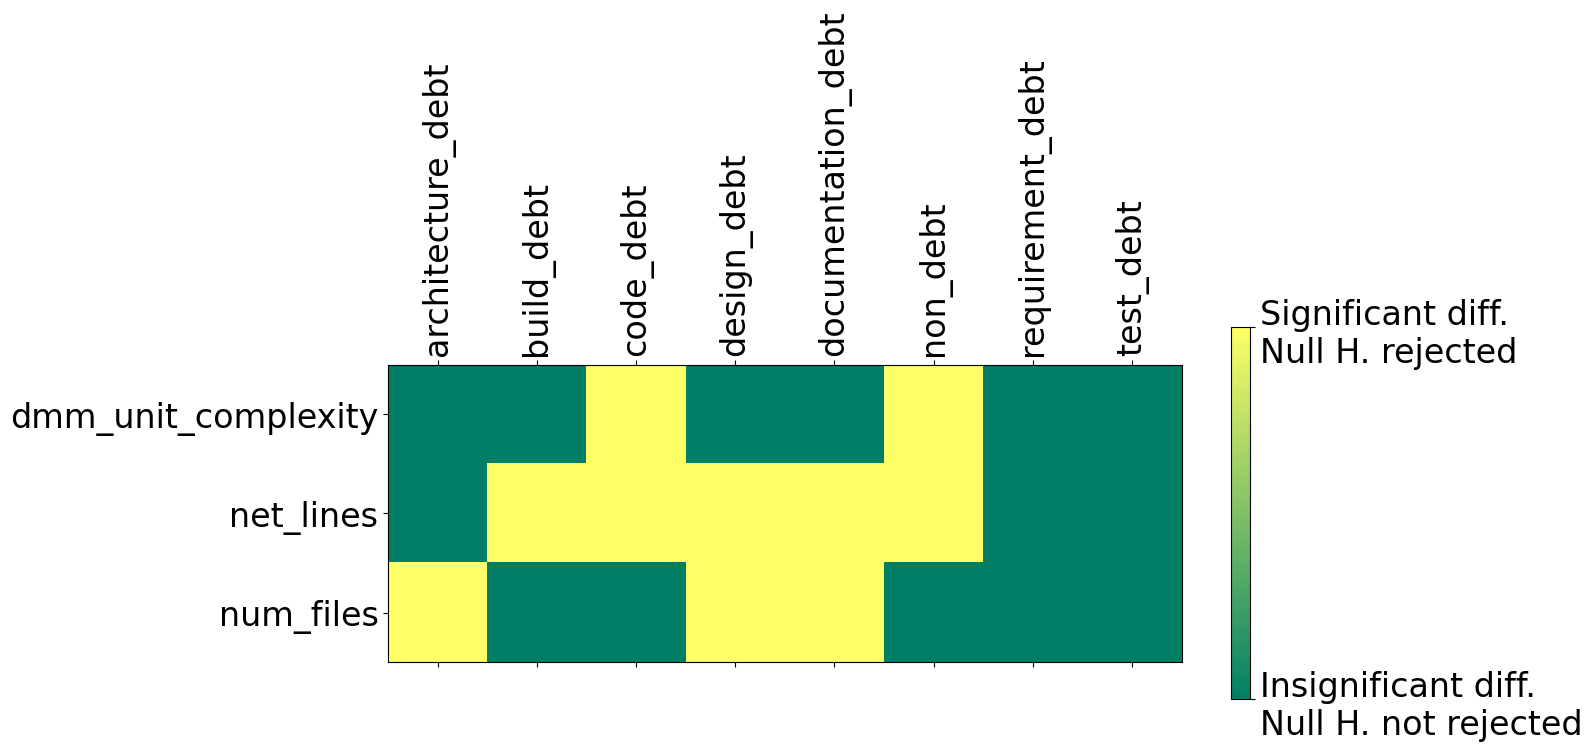

In [28]:
def plot_heatmap_class_to_metric(me_df: pd.DataFrame, value: str, colormap: str = 'Pastel1', clim=None):
    # me_df = me_df[me_df['metric'] == metric]
    _font_size = 24
    me_df = me_df.pivot(index='metric', columns='satd_class', values=value)
    plt.matshow(me_df, cmap=colormap)
    if clim is not None:
        plt.clim(clim)
    plt.xticks(range(len(me_df.columns)), me_df.columns, rotation=90, fontsize=_font_size)
    plt.yticks(range(len(me_df.index)), me_df.index, fontsize=_font_size)
    clb = plt.colorbar()
    clb.set_ticks(
        ticks=[
            False,
            True
        ],
        labels=[
            "Insignificant diff.\nNull H. not rejected",
            "Significant diff.\nNull H. rejected"
        ]
    )
    clb.ax.tick_params(labelsize=_font_size)
    folder = "satd_class_to_metric"
    out_path = f"../data/out/imgs/{folder}"
    Path(out_path).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{out_path}/class_to_metric_{value}.png", bbox_inches='tight')
    # plt.show()


def plots_class_to_metric(data: pd.DataFrame):
    df = data.copy()

    values = {
        # ("stat_val", "coolwarm", (-1, 1)),
        # ("p_value", "Pastel1", None),
        ("reject_null", "summer", (False, True)),
    }

    for (value, colormap, clim) in values:
        plot_heatmap_class_to_metric(df, value, "summer", clim)


plots_class_to_metric(cor_cls_to_mtr)

# Correlation Between Class A and Class B via a given Metric

In [29]:
def manwh_between_classes_for_a_metric(df: pd.DataFrame, cls_a: str, cls_b: str, metric: str):
    # Assuming df is your pandas DataFrame containing the relevant data
    # Selecting data for architecture_debt and code_debt
    a_df = df[df['classification'] == cls_a][metric]
    b_df = df[df['classification'] == cls_b][metric]

    stat_val, p_value = mannwhitneyu(a_df.dropna(), b_df.dropna())

    # Comparing the p-value to a significance level (e.g., 0.05)
    alpha = 0.05

    return {
        "metric": metric,
        "class_a": cls_a,
        "class_b": cls_b,
        "stat_val": stat_val,
        "p_value": p_value,
        # "alpha": alpha,
        "reject_null": p_value < alpha,
        # "result": "Reject Null (significant)" if p_value < alpha else "Fail to reject Null (not significant)"
    }


def all_manwh_between_classes_for_a_metric():
    metrics = {
        'net_lines',
        'num_files',
        'dmm_unit_complexity'
    }

    satd_classes = {
        'architecture_debt',
        'build_debt',
        'code_debt',
        'design_debt',
        'documentation_debt',
        'non_debt',
        'requirement_debt',
        'test_debt',
    }

    df = {
        metric: drop_outliers(DATA.frame.with_outliers, [metric])
        for metric in metrics
    }

    results = (
        manwh_between_classes_for_a_metric(dataframe, cls_a, cls_b, metric)
        for cls_a, cls_b
        in itertools.product(satd_classes, satd_classes)
        for (metric, dataframe) in df.items()
    )

    return pd.DataFrame(results)


mw_cls_to_cls = all_manwh_between_classes_for_a_metric()
mw_cls_to_cls.sort_values(by=["metric", "class_a", "class_b"], inplace=True)
mw_cls_to_cls.to_csv("../data/out/satd_class_test_all.csv", index=False)

metrics = {
    'net_lines',
    'num_files',
    'dmm_unit_complexity'
}

for (mtric, datafr) in ((metric, mw_cls_to_cls[mw_cls_to_cls["metric"] == metric]) for metric in metrics):
    datafr.to_csv(
        f"../data/out/satd_class_test_{mtric}.csv",
        columns=["class_a", "class_b", "stat_val", "p_value", "reject_null"],
        index=False
    )

mw_cls_to_cls

AttributeError: 'OurDataFrame' object has no attribute 'frame'

In [ ]:
def plot_heatmap(me_df: pd.DataFrame, metric: str, value: str, colormap: str = 'Pastel1'):
    me_df = me_df[me_df['metric'] == metric]
    me_df = me_df.pivot(index='class_a', columns='class_b', values=value)
    plt.matshow(me_df, cmap=colormap)
    plt.xticks(range(len(me_df.columns)), me_df.columns, rotation=90)
    plt.yticks(range(len(me_df.columns)), me_df.columns)
    clb = plt.colorbar()
    clb.set_ticks(
        ticks=[
            False,
            True
        ],
        labels=[
            "Insignificant diff.\nNull H. not rejected",
            "Significant diff.\nNull H. rejected"
        ]
    )
    folder = "satd_class_test"
    out_path = f"../data/out/imgs/{folder}"
    Path(out_path).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{out_path}/heatmap_{metric}_{value}.png", bbox_inches='tight')
    # plt.show()


def plots():
    df = mw_cls_to_cls.copy()
    metrics = {
        'net_lines',
        'num_files',
        'dmm_unit_complexity'
    }
    values = {
        # ("stat_val", "coolwarm"),
        # ("p_value", "Pastel1"),
        ("reject_null", "summer"),
    }

    for (metric, (value, colormap)) in itertools.product(metrics, values):
        plot_heatmap(df, metric, value, "summer")


plots()

# Part 2

1.0
                                Comparison   Statistic  P-value  \
0              architecture_debt/net_lines    9369.500    0.678   
1              architecture_debt/num_files    5509.500    0.025   
2    architecture_debt/dmm_unit_complexity   13136.500    0.294   
3                     build_debt/net_lines   62223.500    0.000   
4                     build_debt/num_files   35595.500    0.497   
5           build_debt/dmm_unit_complexity    6075.500    0.065   
6                      code_debt/net_lines  722108.500    0.000   
7                      code_debt/num_files  664076.000    0.358   
8            code_debt/dmm_unit_complexity  282892.500    0.005   
9                    design_debt/net_lines  114158.000    0.060   
10                   design_debt/num_files  142743.500    0.006   
11         design_debt/dmm_unit_complexity   78067.500    0.434   
12            documentation_debt/net_lines  184215.000    0.000   
13            documentation_debt/num_files  204737.000    

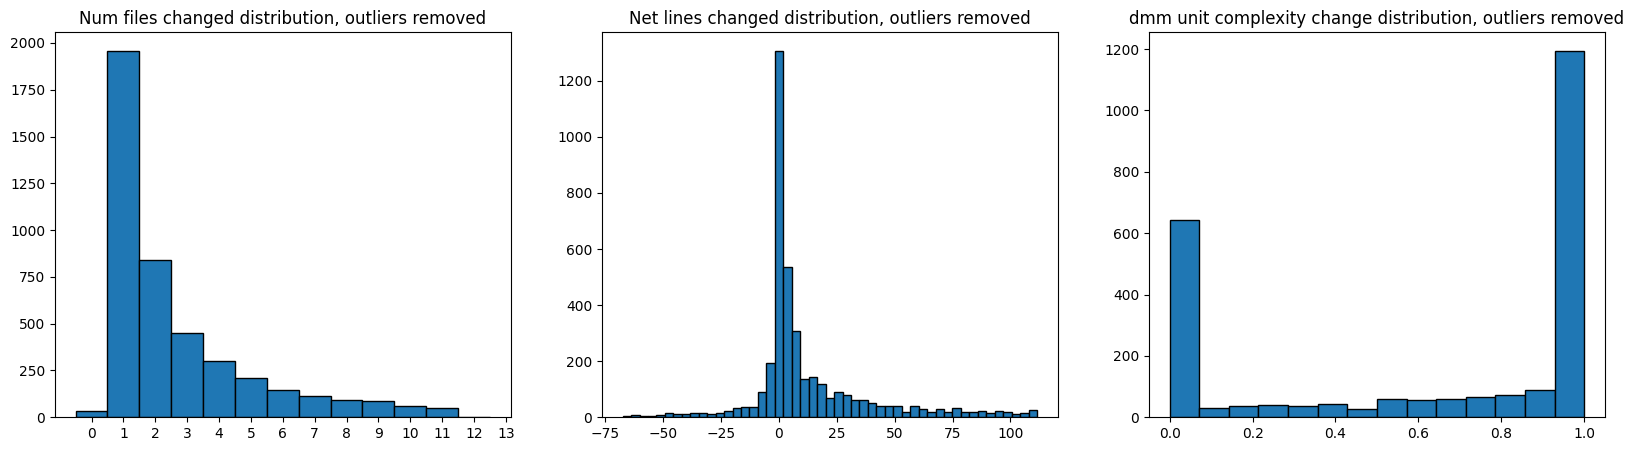

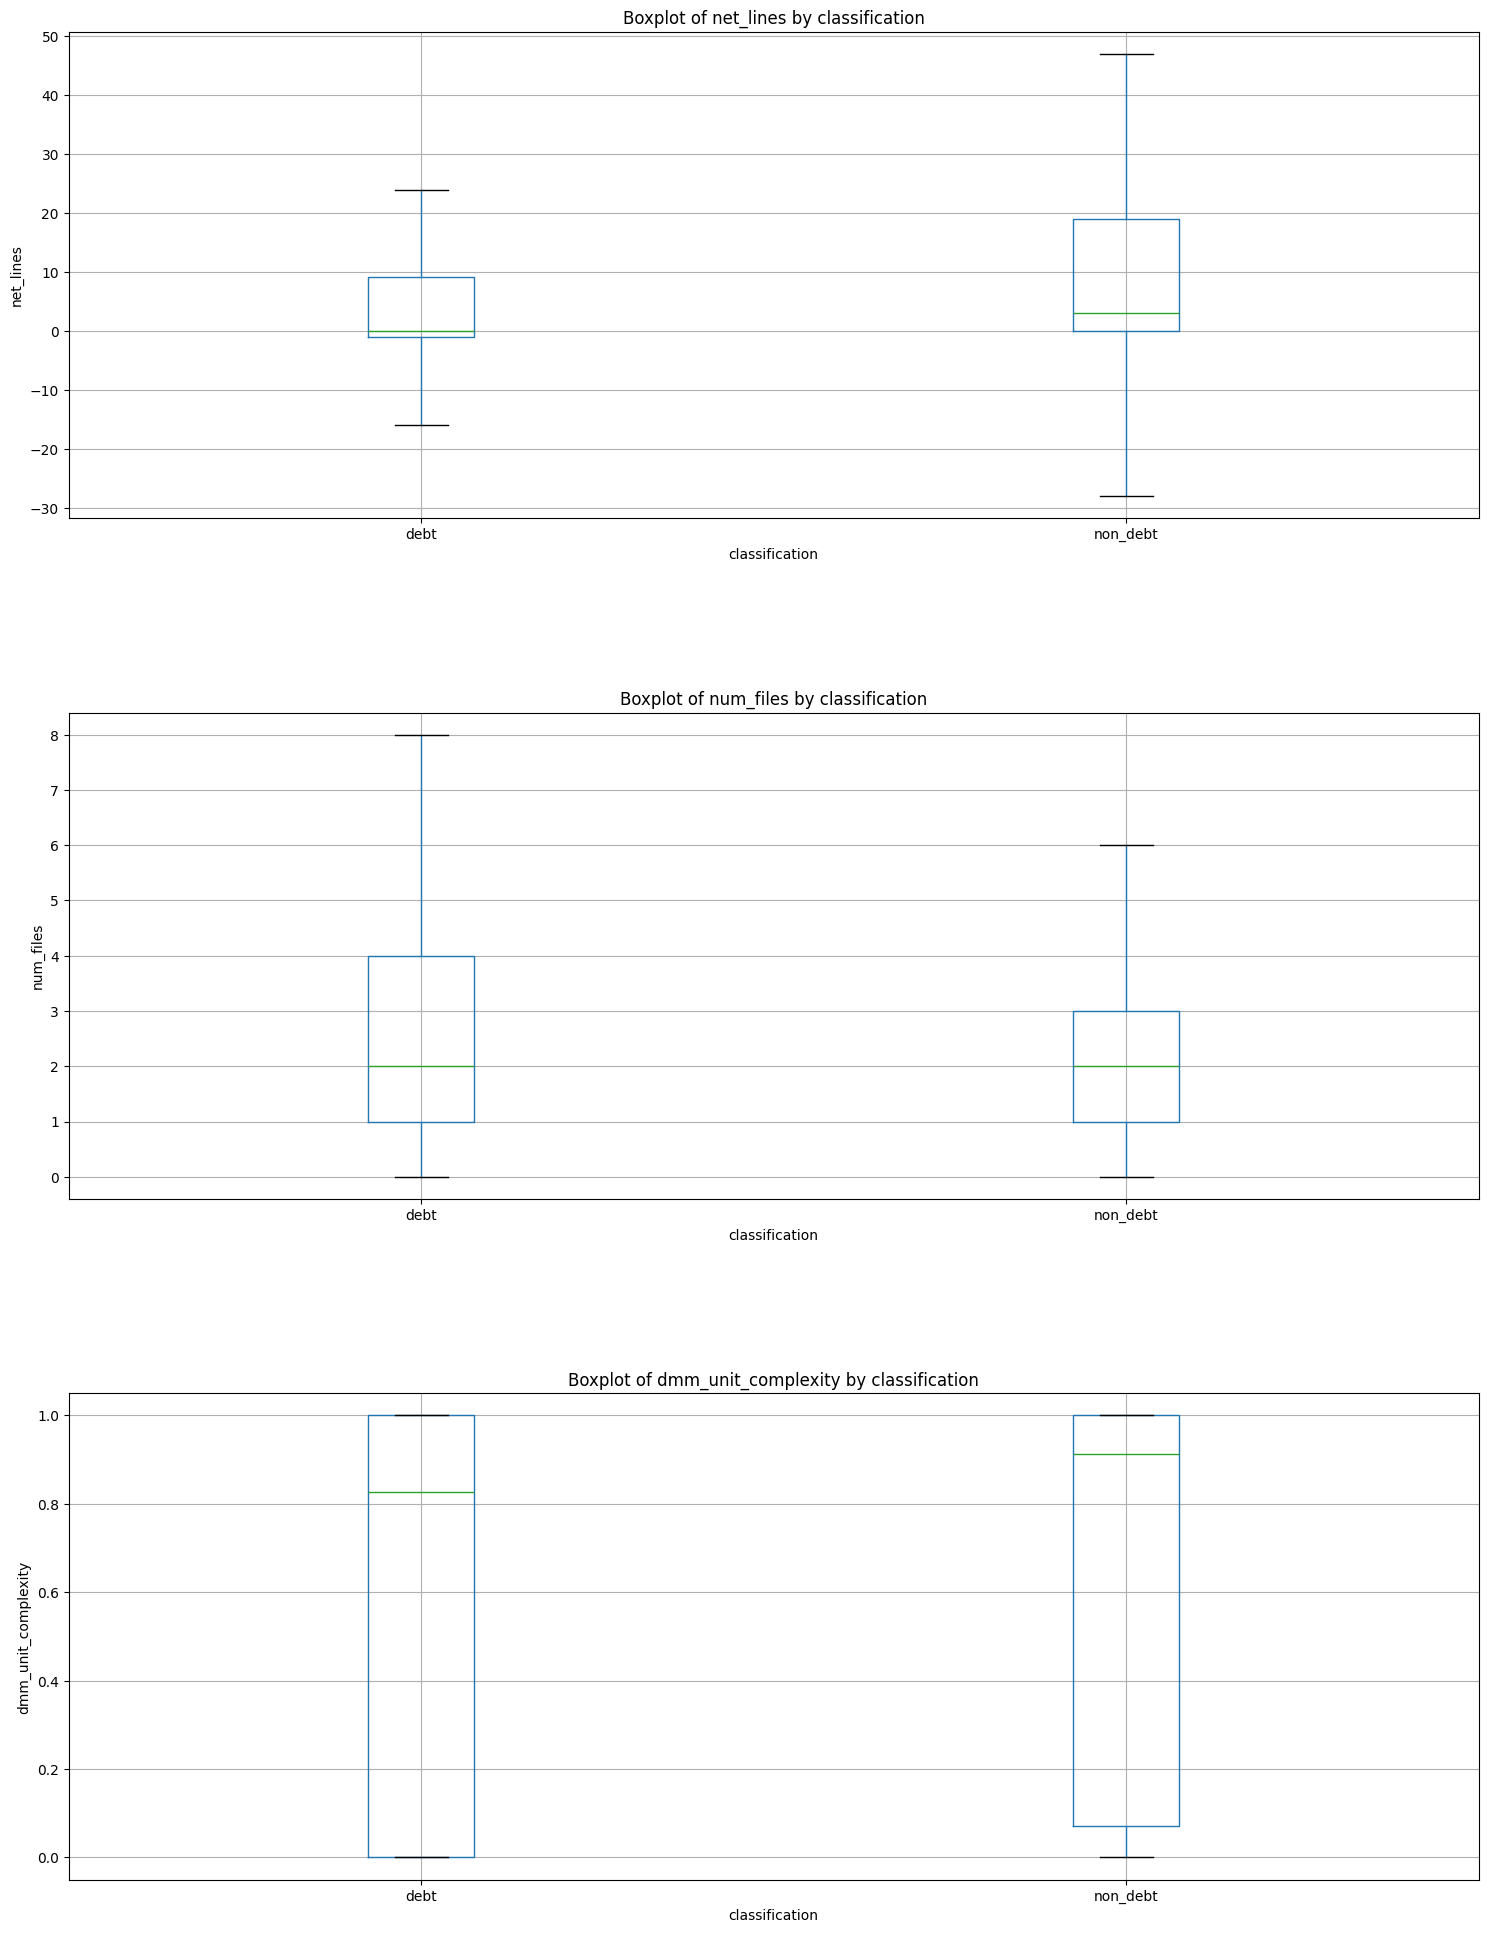

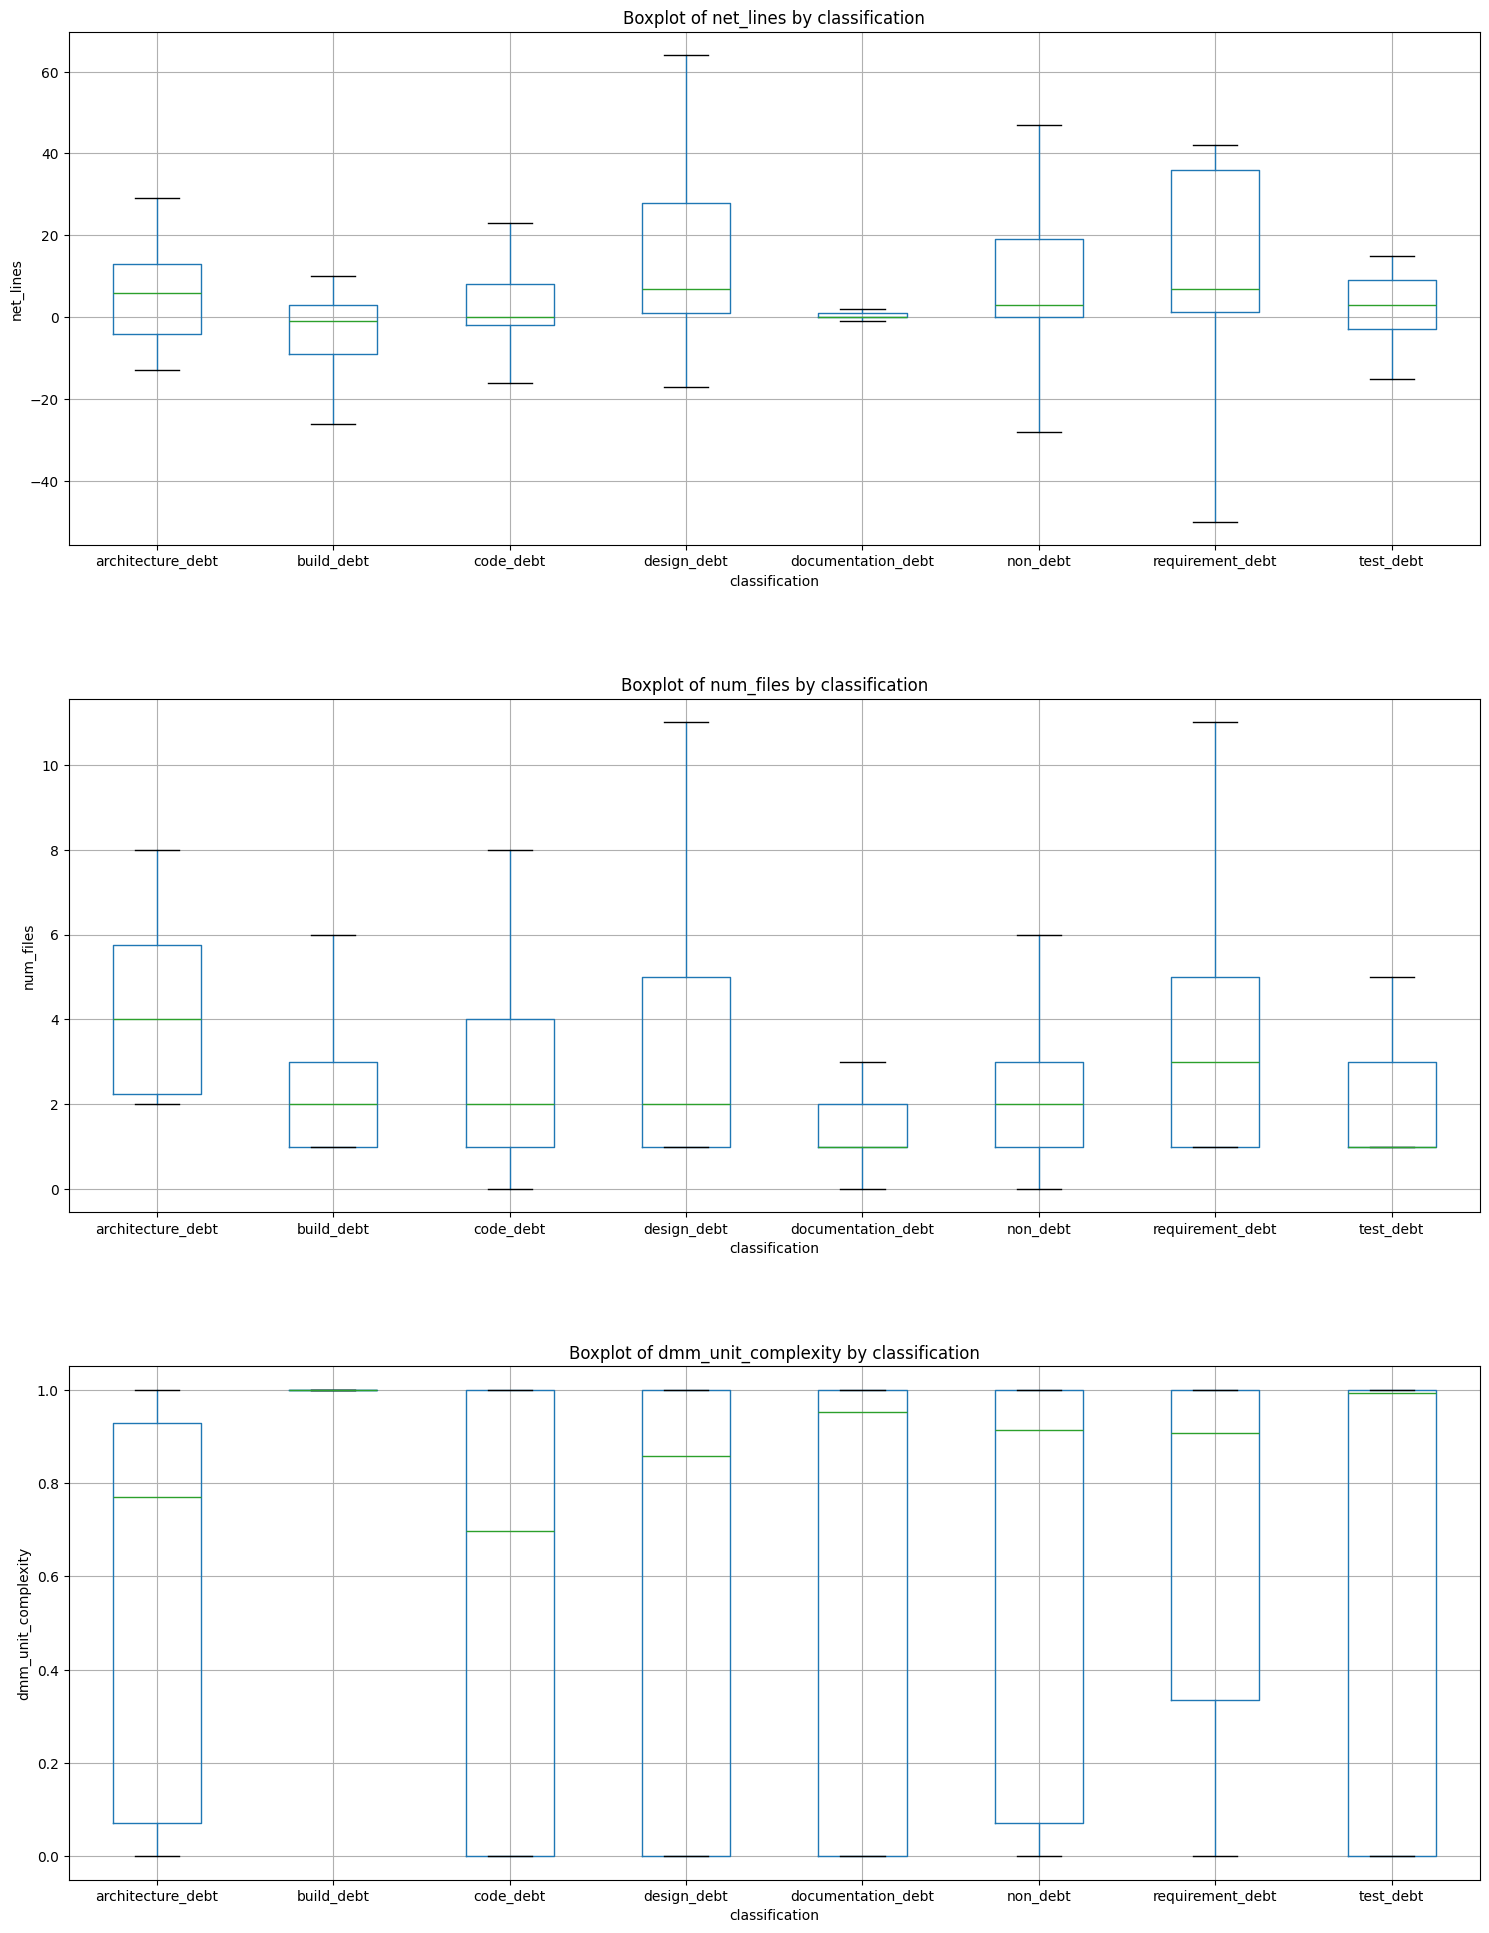

In [49]:
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from scipy.stats import ranksums, mannwhitneyu, kendalltau

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data = pd.read_csv('../data/satd-commits-merged-dataset.csv').filter(
    items=['classification', 'num_files', 'net_lines', 'dmm_unit_complexity'])


def mask_outliers(df, replace):
    # Calculate Q1 and Q2 quantile
    q = df.agg('quantile', q=[.25, .75])

    # Calculate IQR = Q2 - Q1
    iqr = q.loc[.75] - q.loc[.25]

    # Calculate lower and upper limits to decide outliers
    lower = q.loc[.25] - 1.5 * iqr
    upper = q.loc[.75] + 1.5 * iqr

    # Replace the values that does not lies between [lower, upper]
    return df.where(df.ge(lower) & df.le(upper), replace)


removed_outliers: DataFrame = mask_outliers(data[['num_files', 'net_lines', 'dmm_unit_complexity']], np.nan).join(
    data['classification'])

fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
print(max(removed_outliers['dmm_unit_complexity']))
# Plot the first histogram (Num files changed distribution)
axes[0].hist(removed_outliers['num_files'], edgecolor='black', bins=np.arange(14) - 0.5)
axes[0].set_title('Num files changed distribution, outliers removed')
axes[0].set_xticks(range(14))

# Plot the second histogram (Net lines changed distribution)
bins = np.linspace(min(removed_outliers['net_lines']), max(removed_outliers['net_lines']), 50)
axes[1].hist(removed_outliers['net_lines'], edgecolor='black', bins=bins - 0.5)
axes[1].set_title('Net lines changed distribution, outliers removed')

# Plot the second histogram (Net lines changed distribution)
bins2 = np.linspace(min(removed_outliers['dmm_unit_complexity']), max(removed_outliers['dmm_unit_complexity']), 15)
axes[2].hist(removed_outliers['dmm_unit_complexity'], edgecolor='black', bins=bins2)
axes[2].set_title('dmm unit complexity change distribution, outliers removed')
# axes[0].set_xticks(range(14))

non_debt_dataset = removed_outliers[removed_outliers['classification'] == 'non_debt']
debt_dataset = removed_outliers[removed_outliers['classification'] != 'non_debt']

classifiers_simplified_dataset = removed_outliers.copy()
classifiers_simplified_dataset.loc[
    classifiers_simplified_dataset['classification'] != 'non_debt', 'classification'] = 'debt'

# create boxplots for debt vs non-debt
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))

classifiers_simplified_dataset.boxplot(by='classification', column=['net_lines'], showfliers=False, ax=axes[0])
axes[0].set_title('Boxplot of net_lines by classification')
axes[0].set_ylabel('net_lines')

classifiers_simplified_dataset.boxplot(by='classification', column=['num_files'], showfliers=False, ax=axes[1])
axes[1].set_title('Boxplot of num_files by classification')
axes[1].set_ylabel('num_files')

classifiers_simplified_dataset.boxplot(by='classification', column=['dmm_unit_complexity'], showfliers=False,
                                       ax=axes[2])
axes[2].set_title('Boxplot of dmm_unit_complexity by classification')
axes[2].set_ylabel('dmm_unit_complexity')

# Create boxplots for all classifications
fig.suptitle(None, fontsize=16)
plt.tight_layout()

fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(bottom=0.05)
fig.subplots_adjust(left=0.05)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))

removed_outliers.boxplot(by='classification', column=['net_lines'], showfliers=False, ax=axes[0])
axes[0].set_title('Boxplot of net_lines by classification')
axes[0].set_ylabel('net_lines')

removed_outliers.boxplot(by='classification', column=['num_files'], showfliers=False, ax=axes[1])
axes[1].set_title('Boxplot of num_files by classification')
axes[1].set_ylabel('num_files')

removed_outliers.boxplot(by='classification', column=['dmm_unit_complexity'], showfliers=False, ax=axes[2])
axes[2].set_title('Boxplot of dmm_unit_complexity by classification')
axes[2].set_ylabel('dmm_unit_complexity')

# Adjust layout to prevent overlapping
fig.suptitle(None, fontsize=16)
plt.tight_layout()

plt.subplots_adjust(hspace=0.3)
fig.subplots_adjust(bottom=0.05)

# Create an empty DataFrame
result_df = pd.DataFrame(columns=['Comparison', 'Statistic', 'P-value', 'Length of Debt Data'])


# Function to perform Mann-Whitney U test and append the result to the DataFrame
def perform_mannwhitneyu(data1, data2, name):
    stat, p_value = mannwhitneyu(data1, data2)
    result_df.loc[len(result_df)] = [name, stat, p_value, len(data2)]


# Mann-Whitney U tests for each classification compared to non-debt
for name, group in debt_dataset.groupby('classification'):
    perform_mannwhitneyu(non_debt_dataset['net_lines'].dropna(), group['net_lines'].dropna(), f"{name}/net_lines")
    perform_mannwhitneyu(non_debt_dataset['num_files'].dropna(), group['num_files'].dropna(), f"{name}/num_files")
    perform_mannwhitneyu(non_debt_dataset['dmm_unit_complexity'].dropna(), group['dmm_unit_complexity'].dropna(),
                         f"{name}/dmm_unit_complexity")

# Overall Mann-Whitney U tests
perform_mannwhitneyu(non_debt_dataset['net_lines'].dropna(), debt_dataset['net_lines'].dropna(), 'debt/net_lines')
perform_mannwhitneyu(non_debt_dataset['num_files'].dropna(), debt_dataset['num_files'].dropna(), 'debt/num_files')
perform_mannwhitneyu(non_debt_dataset['dmm_unit_complexity'].dropna(), debt_dataset['dmm_unit_complexity'].dropna(),
                     'debt/dmm_unit_complexity')

# Display the result DataFrame
print(result_df)
# print to csv
result_df.to_csv('mannwhitneyu.csv')

plt.show()